In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.nz_model as nz
from lbg_forecast.nz_model import NzModel

In [2]:
def gather_redshifts(nfiles, path):
    i = 0
    nz_data = []
    while(i < nfiles):
        nzs = np.load(path+"redshifts/emulated_redshifts_"+str(i)+".npy", allow_pickle=True)
        nsamples = nzs.shape[0]
        j = 0
        while(j < nsamples):
            nz_data.append(nzs[j, :])
            j+=1
        i+=1

    return np.asarray(nz_data)

In [3]:
def process_redshifts(nzs, bin_size, path):
     
    dz = bin_size
    minz = 0.0
    maxz = 7.0
    bins = np.arange(minz, maxz+dz, dz)

    z_grid = (bins[1:] + bins[0:-1])/2

    dropout = 0
    sample = 0
    nsamples = nzs.shape[0]
    newnzs = np.empty(3, dtype=object)
    while(dropout < 3):
        dropouts = []
        sample = 0
        while(sample < nsamples):
            nzhist = np.histogram(nzs[sample, dropout], density=True, bins=bins)
            dropouts.append(nzhist[0])
            sample+=1
        dropouts = np.asarray(dropouts)
        newnzs[dropout] = dropouts
        dropout+=1
    
    np.save(path+"redshifts/nzus.npy", newnzs[0])
    np.save(path+"redshifts/nzgs.npy", newnzs[1])
    np.save(path+"redshifts/nzrs.npy", newnzs[2])
    np.save(path+"redshifts/z_grid.npy", z_grid)

    return z_grid, newnzs
               


In [4]:
nzs = gather_redshifts(1, path="./")
total_nzs = len(nzs)
print("total nzs:", total_nzs)

total nzs: 128


In [5]:
z_grid, nz_pdfs = process_redshifts(nzs, 0.1, path="./")

In [6]:
nzmodel = NzModel(path="./")

/Users/fpetri/repos/LBGforecast/lbg_forecast/nz_model.py:282: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0, fontsize= 24, frameon=False, ncols=3)


[1.98061242e-02 3.86134926e-03 1.02941081e-03 4.94719112e-04
 1.77369602e-04 1.51004897e-04 1.22974955e-04 8.76954508e-05
 7.84750846e-05 7.42808792e-05 6.95171533e-05 6.64713774e-05
 6.34846048e-05 5.99715888e-05 5.74279934e-05 5.04858644e-05
 4.87138732e-05 4.64445404e-05 4.44954484e-05 4.32187952e-05
 4.04014195e-05 3.86683623e-05 3.64725619e-05 3.53908565e-05
 3.45528684e-05 2.89566697e-05 2.86061855e-05 2.66642182e-05
 2.46742796e-05 2.36383133e-05 2.32156208e-05 2.11081522e-05
 2.00862588e-05 1.87143292e-05 1.63120450e-05 1.54290993e-05
 1.50564488e-05 1.35363101e-05 1.24753643e-05 1.06143970e-05
 8.61182671e-06 4.17055328e-06 7.23006693e-07 2.16925005e-37
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.98061242e-02 3.86134926e-03 1.02941081e-03 4.94719112e-04
 1.77369602e-04 1.51004897e-04 1.22974955e-04 8.76954508e-05
 7.84750846e-05 7.42808792e-05 6.95171533e-05 6.64713774e-05
 6.34846048e-05 5.99715888e-05 5.74279934e-05 5.04858

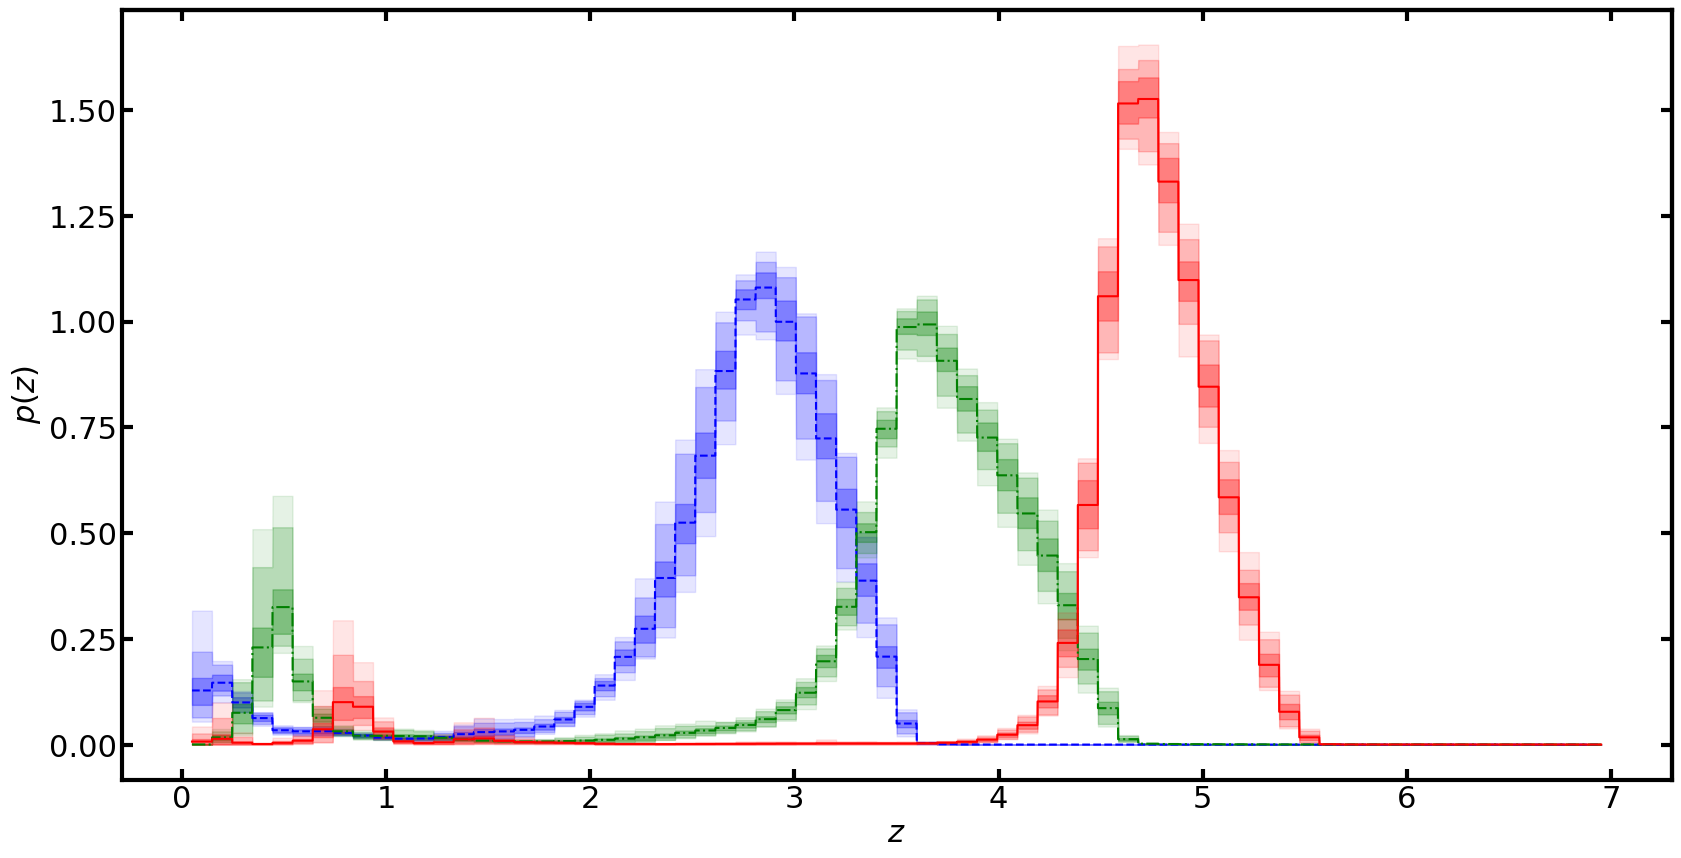

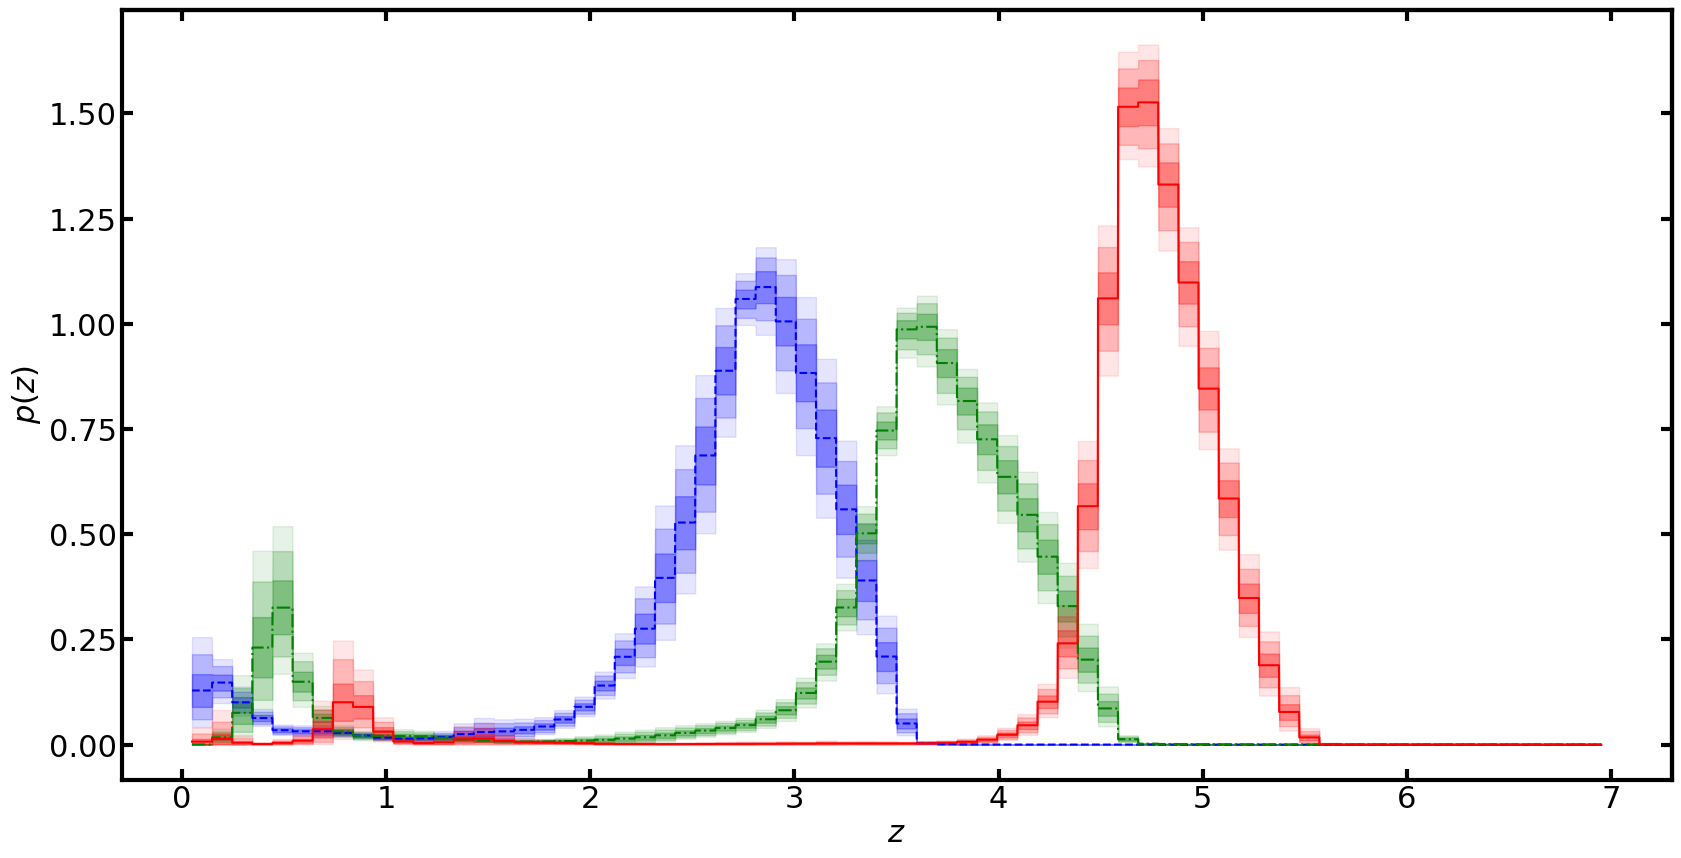

In [7]:
nzmodel.plot_all_data()
nzmodel.plot_all_pca(50, 10000)

In [8]:
k=50
pca_data_u = nz.perform_npca(nzmodel.u_data(), k)
pca_data_g = nz.perform_npca(nzmodel.g_data(), k)
pca_data_r = nz.perform_npca(nzmodel.r_data(), k)

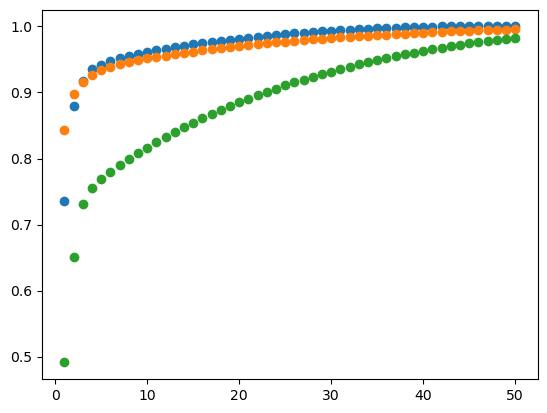

In [9]:
ev_u = pca_data_u[-2]
ev_g = pca_data_g[-2]
ev_r = pca_data_r[-2]
principle_components = np.arange(1, k+1)

cumev_u = np.cumsum(ev_u)
cumev_g = np.cumsum(ev_g)
cumev_r = np.cumsum(ev_r)

plt.scatter(principle_components, cumev_u)
plt.scatter(principle_components, cumev_g)
plt.scatter(principle_components, cumev_r)

In [10]:
pca_data = nz.perform_npca(nzmodel.u_data(), 50)
cov_u = nz.pca_mean_cov(pca_data)[1]

pca_data[-1], cov_u

(array([1.98061242e-02, 3.86134926e-03, 1.02941081e-03, 4.94719112e-04,
        1.77369602e-04, 1.51004897e-04, 1.22974955e-04, 8.76954508e-05,
        7.84750846e-05, 7.42808792e-05, 6.95171533e-05, 6.64713774e-05,
        6.34846048e-05, 5.99715888e-05, 5.74279934e-05, 5.04858644e-05,
        4.87138732e-05, 4.64445404e-05, 4.44954484e-05, 4.32187952e-05,
        4.04014195e-05, 3.86683623e-05, 3.64725619e-05, 3.53908565e-05,
        3.45528684e-05, 2.89566697e-05, 2.86061855e-05, 2.66642182e-05,
        2.46742796e-05, 2.36383133e-05, 2.32156208e-05, 2.11081522e-05,
        2.00862588e-05, 1.87143292e-05, 1.63120450e-05, 1.54290993e-05,
        1.50564488e-05, 1.35363101e-05, 1.24753643e-05, 1.06143970e-05,
        8.61182671e-06, 4.17055328e-06, 7.23006693e-07, 1.01854487e-34,
        1.01854487e-34, 1.01854487e-34, 1.01854487e-34, 1.01854487e-34,
        1.01854487e-34, 1.01854487e-34]),
 array([[1.98061242e-02, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000

print(z_grid.shape)

running_err = []
pcas = np.arange(2, 30, 1)
for npca in pcas:

    binvals = nzmodel.u_data()
    binvals_pca = nzmodel.u_pca(npca, 10000)
    z_grid = nzmodel._z_space

    err = []
    for i in range(z_grid.shape[0]):
        binval = binvals[:, i]
        binval_pca = binvals_pca[:, i]
        if(np.std(binval)!=0):
            err.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
        else:
            err.append(0)


    plt.plot(z_grid, err, color='purple', alpha=(1/npca))

    err=np.array(err)
    err = np.mean(err[np.where(err>0)[0]])
    running_err.append(err)
    print(err)

plt.plot(pcas, running_err)

npca=30

binvals = nzmodel.u_data()
binvals_pca = nzmodel.u_pca(npca, 10000)
z_grid = nzmodel._z_space

error = []
for i in range(z_grid.shape[0]):
    binval = binvals[:, i]
    binval_pca = binvals_pca[:, i]
    if(np.std(binval)!=0):
        error.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
    else:
        error.append(0)

    z=3.0
    if(i == int(z*(1800/7))):
        plt.hist(binval, density = True, alpha=0.5)
        plt.hist(binval_pca, density = True, alpha=0.5)
        print(error[i])

print(z_grid.shape)

running_err = []
pcas = np.arange(2, 30, 1)
for npca in pcas:

    binvals = nzmodel.g_data()
    binvals_pca = nzmodel.g_pca(npca, 10000)
    z_grid = nzmodel._z_space

    err = []
    for i in range(z_grid.shape[0]):
        binval = binvals[:, i]
        binval_pca = binvals_pca[:, i]
        if(np.std(binval)!=0):
            err.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
        else:
            err.append(0)


    plt.plot(z_grid, err, color='purple', alpha=(1/npca))

    err=np.array(err)
    err = np.mean(err[np.where(err>0)[0]])
    running_err.append(err)
    print(err)

plt.plot(pcas, running_err)

npca=30

binvals = nzmodel.g_data()
binvals_pca = nzmodel.g_pca(npca, 10000)
z_grid = nzmodel._z_space

error = []
for i in range(z_grid.shape[0]):
    binval = binvals[:, i]
    binval_pca = binvals_pca[:, i]
    if(np.std(binval)!=0):
        error.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
    else:
        error.append(0)

    z=4.0
    if(i == int(z*(1800/7))):
        plt.hist(binval, density = True, alpha=0.5)
        plt.hist(binval_pca, density = True, alpha=0.5)
        print(error[i])

print(z_grid.shape)

running_err = []
pcas = np.arange(2, 30, 1)
for npca in pcas:

    binvals = nzmodel.r_data()
    binvals_pca = nzmodel.r_pca(npca, 10000)
    z_grid = nzmodel._z_space

    err = []
    for i in range(z_grid.shape[0]):
        binval = binvals[:, i]
        binval_pca = binvals_pca[:, i]
        if(np.std(binval)!=0):
            err.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
        else:
            err.append(0)


    plt.plot(z_grid, err, color='purple', alpha=(1/npca))

    err=np.array(err)
    err = np.mean(err[np.where(err>0)[0]])
    running_err.append(err)
    print(err)

plt.plot(pcas, running_err)

npca=30

binvals = nzmodel.r_data()
binvals_pca = nzmodel.r_pca(npca, 10000)
z_grid = nzmodel._z_space

error = []
for i in range(z_grid.shape[0]):
    binval = binvals[:, i]
    binval_pca = binvals_pca[:, i]
    if(np.std(binval)!=0):
        error.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
    else:
        error.append(0)

    z=5.0
    if(i == int(z*(1800/7))):
        plt.hist(binval, density = True, alpha=0.5)
        plt.hist(binval_pca, density = True, alpha=0.5)
        print(error[i])